![dvd_image](dvd_image.jpg)

A DVD rental company needs your help! They want to figure out how many days a customer will rent a DVD for based on some features and has approached you for help. They want you to try out some regression models which will help predict the number of days a customer will rent a DVD for. The company wants a model which yeilds a MSE of 3 or less on a test set. The model you make will help the company become more efficient inventory planning.

The data they provided is in the csv file `rental_info.csv`. It has the following features:
- `"rental_date"`: The date (and time) the customer rents the DVD.
- `"return_date"`: The date (and time) the customer returns the DVD.
- `"amount"`: The amount paid by the customer for renting the DVD.
- `"amount_2"`: The square of `"amount"`.
- `"rental_rate"`: The rate at which the DVD is rented for.
- `"rental_rate_2"`: The square of `"rental_rate"`.
- `"release_year"`: The year the movie being rented was released.
- `"length"`: Lenght of the movie being rented, in minuites.
- `"length_2"`: The square of `"length"`.
- `"replacement_cost"`: The amount it will cost the company to replace the DVD.
- `"special_features"`: Any special features, for example trailers/deleted scenes that the DVD also has.
- `"NC-17"`, `"PG"`, `"PG-13"`, `"R"`: These columns are dummy variables of the rating of the movie. It takes the value 1 if the move is rated as the column name and 0 otherwise. For your convinience, the reference dummy has already been dropped.

In [346]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
# Import any additional modules and start coding below

In [331]:
# Read the rental_info.csv file 
rental_info = pd.read_csv('rental_info.csv') 

In [332]:
# Explore the dataframe before analysis
rental_info.head(5)

,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
3,2005-07-31 12:06:41+00:00,2005-08-02 14:30:41+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
4,2005-08-19 12:30:04+00:00,2005-08-23 13:35:04+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401


In [333]:
rental_info.shape

(15861, 15)

In [334]:
rental_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15861 entries, 0 to 15860
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rental_date       15861 non-null  object 
 1   return_date       15861 non-null  object 
 2   amount            15861 non-null  float64
 3   release_year      15861 non-null  float64
 4   rental_rate       15861 non-null  float64
 5   length            15861 non-null  float64
 6   replacement_cost  15861 non-null  float64
 7   special_features  15861 non-null  object 
 8   NC-17             15861 non-null  int64  
 9   PG                15861 non-null  int64  
 10  PG-13             15861 non-null  int64  
 11  R                 15861 non-null  int64  
 12  amount_2          15861 non-null  float64
 13  length_2          15861 non-null  float64
 14  rental_rate_2     15861 non-null  float64
dtypes: float64(8), int64(4), object(3)
memory usage: 1.8+ MB


In [335]:
rental_info.describe()

,amount,release_year,rental_rate,length,replacement_cost,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2
count,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000
mean,4.217161,2006.885379,2.944101,114.994578,20.224727,0.204842,0.200303,0.223378,0.198726,23.355504,14832.841876,11.389287
std,2.360383,2.025027,1.649766,40.114715,6.083784,0.403599,0.400239,0.416523,0.399054,23.503164,9393.431996,10.005293
min,0.990000,2004.000000,0.990000,46.000000,9.990000,0.000000,0.000000,0.000000,0.000000,0.980100,2116.000000,0.980100
25%,2.990000,2005.000000,0.990000,81.000000,14.990000,0.000000,0.000000,0.000000,0.000000,8.940100,6561.000000,0.980100
50%,3.990000,2007.000000,2.990000,114.000000,20.990000,0.000000,0.000000,0.000000,0.000000,15.920100,12996.000000,8.940100
75%,4.990000,2009.000000,4.990000,148.000000,25.990000,0.000000,0.000000,0.000000,0.000000,24.900100,21904.000000,24.900100
max,11.990000,2010.000000,4.990000,185.000000,29.990000,1.000000,1.000000,1.000000,1.000000,143.760100,34225.000000,24.900100


In [336]:
# Convert rental_date and return_date to datetime
rental_info['rental_date'] = pd.to_datetime(rental_info['rental_date'])
rental_info['return_date'] = pd.to_datetime(rental_info['return_date'])

# calculating rental_length_days
rental_info['rental_length_days'] = (rental_info['return_date'] - rental_info['rental_date']).dt.days
 
# Checking the result 
rental_info.head(5)

,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2,rental_length_days
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,3
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,2
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,7
3,2005-07-31 12:06:41+00:00,2005-08-02 14:30:41+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,2
4,2005-08-19 12:30:04+00:00,2005-08-23 13:35:04+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,4


In [337]:
# Creating columns for deleted_scenes and behind_the_scenes
rental_info['deleted_scenes'] = np.where(rental_info['special_features'].str.contains('Deleted Scenes'),1,0)
rental_info['behind_the_scenes'] = np.where(rental_info['special_features'].str.contains('Behind the Scenes'),1,0)
rental_info.head(5)

,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2,rental_length_days,deleted_scenes,behind_the_scenes
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,3,0,1
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,2,0,1
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,7,0,1
3,2005-07-31 12:06:41+00:00,2005-08-02 14:30:41+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,2,0,1
4,2005-08-19 12:30:04+00:00,2005-08-23 13:35:04+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401,4,0,1


In [338]:
# Choose columns to drop and split into feature and target sets
X = rental_info.drop(['special_features', 'rental_date', 'return_date', 'rental_length_days'], axis=1)
y = rental_info['rental_length_days']

In [339]:
# Split into feature and target sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=9)

In [340]:
# Initialise the models and create a dictionary for the models
lr = LinearRegression()
rf = RandomForestRegressor()
dt = DecisionTreeRegressor()

models = {'LinearRegression': lr, 'RandomForestRegressor': rf, 'DecisionTreeRegressor': dt}

In [341]:
# Create a dictionary for the hyperparams of RandomizedSearchCV
params = {
    'LinearRegression': {
        'fit_intercept': [True, False],
        'copy_X': [True, False],
        'n_jobs': [-1, 1, 2, 4]
    },
    'RandomForestRegressor': {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 15, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt', 'log2'],
    },
    'DecisionTreeRegressor': {
        'max_depth': [10, 15, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt', 'log2'],
    }
}

In [342]:
# Execute RandomizedSearchCV and store best estimators in a dictionary
best_estimators = {}
kf = KFold(n_splits=5, random_state=9, shuffle=True)
for model_name, model in models.items():
    random_result = RandomizedSearchCV(
        estimator=model,
        param_distributions=params[model_name],
        n_iter=20,
        cv=kf,
        scoring='neg_mean_squared_error',
        random_state=9,
        n_jobs=-1
    )
    random_result.fit(X_train, y_train)
    # Negate the negative MSE score to get a positive score
    best_score = -random_result.best_score_
    
    print(f"Best parameters for {model_name}: {random_result.best_params_}")
    print(f"Best score for {model_name}: {best_score}")
    best_estimators[model_name] = random_result.best_estimator_

Best parameters for LinearRegression: {'n_jobs': -1, 'fit_intercept': False, 'copy_X': True}
Best score for LinearRegression: 2.8668335369530045
Best parameters for RandomForestRegressor: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 15}
Best score for RandomForestRegressor: 2.0205609693973092
Best parameters for DecisionTreeRegressor: {'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 20}
Best score for DecisionTreeRegressor: 2.2521878287949013


In [343]:
# Calculating mean squared error on the test set
mean_squared_errors = {}
for model_name, model in best_estimators.items():
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mean_squared_errors[model_name] = mse
print(mean_squared_errors)    

{'LinearRegression': 2.8754680514941233, 'RandomForestRegressor': 2.029463591552589, 'DecisionTreeRegressor': 2.220631334913928}


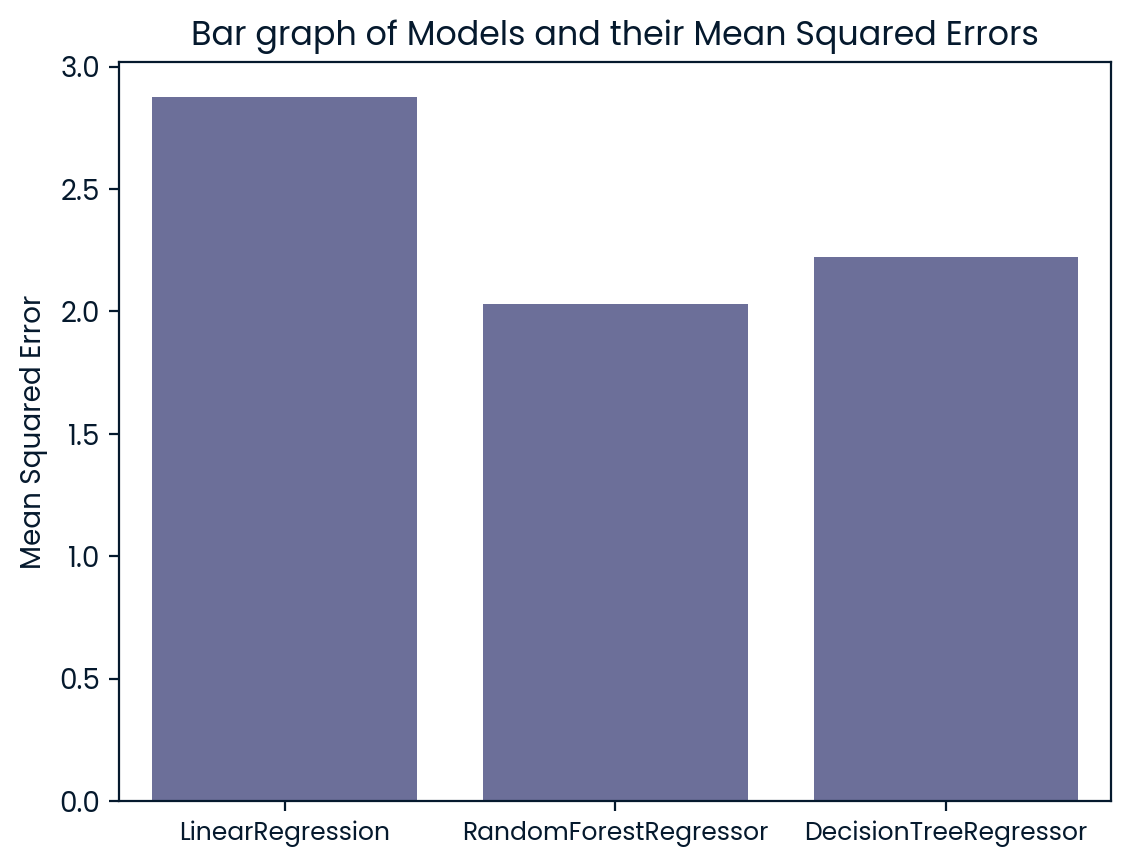

In [355]:
# Visualizing mean_squared_erorrs of different models
sns.barplot(x=mean_squared_errors.keys(), y=mean_squared_errors.values())
plt.xticks(size=9)
plt.ylabel('Mean Squared Error')
plt.title('Bar graph of Models and their Mean Squared Errors')
plt.show()

In [344]:
# Declaring the best model and the best_mse as variables
best_model = models['RandomForestRegressor']
best_mse = mean_squared_errors['RandomForestRegressor']
print(best_model)
print(best_mse)

RandomForestRegressor()
2.029463591552589
